## Import Packages and Authenticate

In [1]:
# Dependencies
import tweepy
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from config import (consumer_key, consumer_secret,
                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

## Pull Mentions

In [2]:
# Search for all tweets with "@JohnZalk Analyze:"
search_term = "@JohnZalk Analyze:"

# List of mentions
mention_list = []

mentions = api.search(search_term, count=100)

for mention in mentions["statuses"]:
    
    # add tweets to the list
    mention_list.append({'User' : '@' + mention["user"]["screen_name"],
                         'Account' : mention["text"].split(": ",1)[1],
                         # convert date
                         'Date' : time.strftime('%Y-%m-%d %H:%M:%S',
                                                time.strptime(mention['created_at'],
                                                              '%a %b %d %H:%M:%S +0000 %Y'))})

# turn tweets to df
mention_list

[{'User': '@JohnZalk', 'Account': '@Cristiano', 'Date': '2019-11-08 15:11:56'},
 {'User': '@JohnZalk', 'Account': '@espn', 'Date': '2019-11-07 15:55:35'},
 {'User': '@JohnZalk',
  'Account': '@DennisRodman',
  'Date': '2019-11-07 15:46:30'},
 {'User': '@JohnZalk',
  'Account': '@DwyaneWade',
  'Date': '2019-11-07 15:19:24'},
 {'User': '@JohnZalk',
  'Account': '@BarackObama',
  'Date': '2019-11-07 15:18:04'},
 {'User': '@JohnZalk', 'Account': '@espn', 'Date': '2019-11-06 13:49:34'}]

In [3]:
mention_df = pd.DataFrame(mention_list)
mention_df.head()

,Account,Date,User
0,@Cristiano,2019-11-08 15:11:56,@JohnZalk
1,@espn,2019-11-07 15:55:35,@JohnZalk
2,@DennisRodman,2019-11-07 15:46:30,@JohnZalk
3,@DwyaneWade,2019-11-07 15:19:24,@JohnZalk
4,@BarackObama,2019-11-07 15:18:04,@JohnZalk


In [4]:
import datetime
five_min_ago = datetime.datetime.now() - datetime.timedelta(minutes=5)
five_min_ago

datetime.datetime(2019, 11, 8, 10, 7, 19, 329618)

In [5]:
#filter out mentions outside of last 5 mins 
mention_df[(mention_df['Date'] > str(five_min_ago))]

,Account,Date,User
0,@Cristiano,2019-11-08 15:11:56,@JohnZalk


In [15]:
# if not mention_df.empty:

False

In [6]:
#remove Account that have been mentioned twice
counts = mention_df['Account'].value_counts()
counts

counts = counts.to_dict() #converts to dictionary

#add counts to mentions df
mention_df['Count'] = mention_df['Account'].map(counts) 

#remove counts > 1
mention_df = mention_df[mention_df.Count < 2]
mention_df

,Account,Date,User,Count
0,@Cristiano,2019-11-08 15:11:56,@JohnZalk,1
2,@DennisRodman,2019-11-07 15:46:30,@JohnZalk,1
3,@DwyaneWade,2019-11-07 15:19:24,@JohnZalk,1
4,@BarackObama,2019-11-07 15:18:04,@JohnZalk,1


In [7]:
#take most recent mention
recent_date = mention_df['Date'].max()
mention_df=mention_df[mention_df['Date'] == recent_date]
mention_df
#turn account value to string
target_account = mention_df.iloc[0]['Account']
#turn user value to string
user = mention_df.iloc[0]['User']
user

'@JohnZalk'

## Pull Last 500 Tweets and Store in DF

In [8]:
tweet_list =[]

# Loop through 21 pages of tweets (total 500 tweets)
for x in range(1, 21):

    # Get all tweets from home feed
    tweets = api.user_timeline(target_account, page=x)

    # Loop through all tweets and print the tweet text
    for tweet in tweets:
        tweet_list.append(tweet['text'])
        
tweet_list
tweet_df = pd.DataFrame(tweet_list)
tweet_df.head()

,0
0,We’re on the #ucl last 16!👍\nBravi Ragazzi!💪\n...
1,Champions League here we go again!😜✈️ https://...
2,The Show started with Love💏 https://t.co/FCz9L...
3,Happy Halloween everyone 🎃👻 https://t.co/2kjIZ...
4,#finoallafine 👍🏽💪🏽 https://t.co/YfNFCoWJxN


In [9]:
#rename column
tweet_df.rename(columns = {0:'Tweet'}, inplace = True)
##create column Tweets Ago for x axis of sentiment plot
# count nuber of tweets becuase not all accounts have 500 and make number negative
number_tweets = -len(tweet_df)
#create an array 0 through number_tweets
tweets_ago = np.arange(0,number_tweets,-1)
#add array as column in df
tweet_df['Tweets Ago'] = tweets_ago
# create polarity column that's 0 for now
tweet_df['Tweet Polarity'] = 0
tweet_df.head()

,Tweet,Tweets Ago,Tweet Polarity
0,We’re on the #ucl last 16!👍\nBravi Ragazzi!💪\n...,0,0
1,Champions League here we go again!😜✈️ https://...,-1,0
2,The Show started with Love💏 https://t.co/FCz9L...,-2,0
3,Happy Halloween everyone 🎃👻 https://t.co/2kjIZ...,-3,0
4,#finoallafine 👍🏽💪🏽 https://t.co/YfNFCoWJxN,-4,0


## Compute Polarity Score

In [10]:
# loop through tweets and compute polarity score. Append score to list.
polarity=[]
for row in tweet_df['Tweet']:
    results = analyzer.polarity_scores(row)
    polarity.append(results['compound'])

# turn list into df column
tweet_df['Tweet Polarity'] = polarity
tweet_df.head()

,Tweet,Tweets Ago,Tweet Polarity
0,We’re on the #ucl last 16!👍\nBravi Ragazzi!💪\n...,0,0.0000
1,Champions League here we go again!😜✈️ https://...,-1,0.5707
2,The Show started with Love💏 https://t.co/FCz9L...,-2,0.0000
3,Happy Halloween everyone 🎃👻 https://t.co/2kjIZ...,-3,0.5719
4,#finoallafine 👍🏽💪🏽 https://t.co/YfNFCoWJxN,-4,0.0000


## Plot

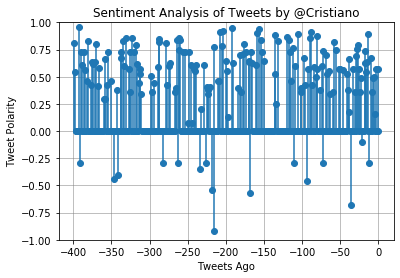

In [11]:
plt.stem(tweet_df['Tweets Ago'], tweet_df['Tweet Polarity'], basefmt=' ', use_line_collection = True)
plt.title("Sentiment Analysis of Tweets by " + target_account)
plt.ylabel('Tweet Polarity')
plt.xlabel("Tweets Ago")
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.ylim(-1,1)
#/app/tmp/
plt.savefig('sentiment_plot.png')

## Tweet Plot

In [12]:
#Create message for status update
message ='New Tweet Analysis: ' + target_account + ' (Thx ' + user + '!!)'
message

'New Tweet Analysis: @Cristiano (Thx @JohnZalk!!)'

In [13]:
# Tweet the plot
api.update_with_media('sentiment_plot.png', status=message)

{'created_at': 'Fri Nov 08 15:12:26 +0000 2019',
 'id': 1192822192372953090,
 'id_str': '1192822192372953090',
 'text': 'New Tweet Analysis: @Cristiano (Thx @JohnZalk!!) https://t.co/UpaMS57r2H',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Cristiano',
    'name': 'Cristiano Ronaldo',
    'id': 155659213,
    'id_str': '155659213',
    'indices': [20, 30]},
   {'screen_name': 'JohnZalk',
    'name': 'John van Zalk',
    'id': 1183870841873993728,
    'id_str': '1183870841873993728',
    'indices': [36, 45]}],
  'urls': [],
  'media': [{'id': 1192822190372196353,
    'id_str': '1192822190372196353',
    'indices': [49, 72],
    'media_url': 'http://pbs.twimg.com/media/EI3BdllWkAEkXav.png',
    'media_url_https': 'https://pbs.twimg.com/media/EI3BdllWkAEkXav.png',
    'url': 'https://t.co/UpaMS57r2H',
    'display_url': 'pic.twitter.com/UpaMS57r2H',
    'expanded_url': 'https://twitter.com/JohnZalk/status/1192822192372953090/phot

# packages in environment at C:\Users\jvanzalk\AppData\Local\Continuum\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  2019.07                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.7                    py37_0  
anaconda-project          0.8.3                      py_0  
asn1crypto                0.24.0                   py37_0  
astroid                   2.2.5                    py37_0  
astropy                   3.2.1            py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.1.0                   py37_1  
babel                     2.7.0                      py_0  
backcall                  0.1.0                    py37_0  
backports                 1.0                        py_2  
backports